In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

# Jonathan Scott

# Resources
https://rachellegardner.com/isbn-10-isbn-13-and-those-pesky-x%E2%80%99s/

https://sellercentral.amazon.com/forums/thread.jspa?threadID=17640

https://stackoverflow.com/questions/7881994/matplotlib-how-to-change-data-points-color-based-on-some-variable

https://matplotlib.org/examples/mplot3d/scatter3d_demo.html

# Background

The task was using a Lab-41 dataset create a simple recommender system. Before I started the challenge  I knew nothing about machine learning let alone deep learning. In an attempt to fix this I took a Udemy course on deep learning. In the course the instructor used a Stacked AutoEncoder to make a simple recommender system. I thought I could try to do the same thing. I had problems getting the model to perform to my liking as I was experiecing overfitting. I discuss this later on.

### Importing the dataset
I am using a MacBook Pro (Retina, 13-inch, Early 2015) with 8 GB 1867 MHz DDR3 of RAM. 
I also used the scientific IDE Spyder before transferring my work into this jupyter notebook, which when idle uses around 76% of my memory. This means that I do not have much space left for using the entire bx-data set. 

In [73]:
#books = pd.read_csv('BX-CSV-Dump/BX-Books.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False)
#users = pd.read_csv('BX-CSV-Dump/BX-Users.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False)
n = 1149767 #number of records in file
s = 10000 #desired sample size
skip = sorted(random.sample(xrange(n),n-s))
ratings = pd.read_csv('BX-CSV-Dump/BX-Book-Ratings.csv', sep = ';', header = None,engine= 'python',encoding = 'latin-1',error_bad_lines=False,skiprows=skip)
skip = [] #free(skip)

Skipping line 21689: ';' expected after '"'
Skipping line 45329: ';' expected after '"'
Skipping line 45330: ';' expected after '"'
Skipping line 183262: ';' expected after '"'
Skipping line 210093: ';' expected after '"'
Skipping line 531938: ';' expected after '"'
Skipping line 663237: ';' expected after '"'
Skipping line 824822: ';' expected after '"'
Skipping line 877349: ';' expected after '"'
Skipping line 941679: ';' expected after '"'
Skipping line 1134132: ';' expected after '"'
Skipping line 1145176: ';' expected after '"'
Skipping line 1145177: ';' expected after '"'
Skipping line 1148551: ';' expected after '"'


### Data Inspection and Visualzation

In [91]:
ratings.head()

,0,1,2
0,276774,3423111321,0
1,276847,3442441080,10
2,276847,3499433443,8
3,276847,3551551685,10
4,276925,2290309494,0


We are focused on the ratings data. The first column is a user-id, the second column is a ISBN number for a book and the third column is a book rating given by a user. After inspecting more of the ISBN number column, I noticed that not all entries are integers, some had X's in them. Which would make it hard to input into a neural network so I decided to map the userIDs and the ISBN numbers to smaller integers in order to have in a format that the PyTorch module can work with.

#### Mapping of userIds and ISBN columns

In [75]:
#remap USER IDs, so it is easy to get nb_users
id_users = ratings[0].unique()
user_map = {}
user_count = 0
for user in id_users:
    user_map[user] = user_count
    user_count+=1

In [76]:
id_books = ratings[1].unique()
books_map = {}
book_count = 0
for book in id_books:
    books_map[book] = book_count
    book_count+=1

In [77]:
ratings_user_mapped = ratings[0].map(user_map)
ratings_book_mapped = ratings[1].map(books_map)
pieces = [ratings_user_mapped, ratings_book_mapped ,ratings[2]]
mapped_ratings = pd.concat(pieces,axis=1)

In [105]:
mapped_ratings.head(5)

,0,1,2
0,0,0,0
1,1,1,10
2,1,2,8
3,1,3,10
4,2,4,0


Now with these mapped ratings, it is easier to visualize the data based on book ratings.
But there are way to many points to see any helpful relationships.

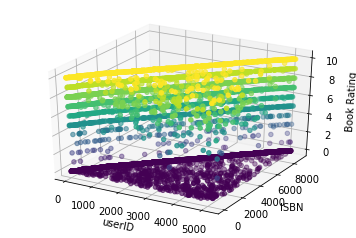

In [79]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(mapped_ratings[0], mapped_ratings[1], mapped_ratings[2],c=mapped_ratings[2])
ax.set_xlabel('userID')
ax.set_ylabel('ISBN')
ax.set_zlabel('Book Rating')
plt.show()

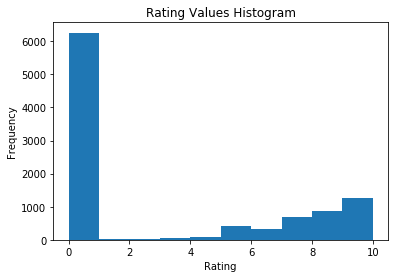

In [103]:
plt.hist(mapped_ratings[2])#frequency of rating values
plt.title("Rating Values Histogram")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

**Many books in my sample of the dataset were not rated by users. We also do not have a good distribution of other ratings.**

## Training and Test set data split


In [80]:
training_set, test_set = train_test_split(mapped_ratings,test_size=0.20)
training_set = np.array(training_set, dtype = 'int')
test_set = np.array(test_set, dtype = 'int')

In [81]:
# Getting the number of users and books
nb_users = int(max(max(training_set[:,0]),max(test_set[:,0])))
nb_books = int(max(max(training_set[:,1]),max(test_set[:,1])))

In [82]:
# Converting the data into an array with users in lines and books in columns
def convert(data): #check
    new_data = []
    for id_user in range(0, nb_users):
        id_book = data[:,1][data[:,0] == id_user]
        id_ratings = data[:,2][data[:,0] == id_user]
        ratings = np.zeros(nb_books)
        ratings[id_book] = id_ratings #numpy matches things up.
        new_data.append(list(ratings))
    return new_data

In [83]:
training_set = convert(training_set)
test_set = convert(test_set)


In [84]:
# Converting the data into Torch tensors
# tensors are mutlidimensional arrays that contain elements of a single data type.
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

# Creating the architecture of the Neural Network

In [85]:
class SAE(nn.Module):
    def __init__(self):
        super(SAE,self).__init__()
        self.fc1 = nn.Linear(nb_books, 20)#with 20 we trying to detect 20 features
        self.fc2 = nn.Linear(20, 10)
        #self.dropout = nn.Dropout(0.5)
        self.fc3 = nn.Linear(10, 20 )#reconstructing matches first encode
        #self.dropout_2 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(20, nb_books )#reconstructed features
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        #x = self.dropout(x)
        x = self.activation(self.fc3(x))
        #x = self.dropout_2(x)
        x = self.fc4(x) #vector of predicted ratings
        return x

In [86]:
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5) # decay decrease learning rate every few epochs

### Training the SAE

In [87]:
nb_epoch = 50 #100,200 causes overfitting anyways, dropout did not help.
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)#pytorch needs this dummy dimension
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False # don't compare against target
            output[target == 0] = 0
            loss = criterion(output,target)
            mean_corrector = nb_books/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data[0]*mean_corrector) #this has the loss in the loss object
            s += 1.
            optimizer.step()
    print('epoch: ' + str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: 7.577030860132892
epoch: 2 loss: 7.564646790125606
epoch: 3 loss: 7.540401882482371
epoch: 4 loss: 7.515159060785696
epoch: 5 loss: 7.488174354138215
epoch: 6 loss: 7.458620753022409
epoch: 7 loss: 7.425589200475038
epoch: 8 loss: 7.38800306908648
epoch: 9 loss: 7.344635095073243
epoch: 10 loss: 7.294202251511719
epoch: 11 loss: 7.235781575567776
epoch: 12 loss: 7.169502987466799
epoch: 13 loss: 7.096990118758535
epoch: 14 loss: 7.020841872623477
epoch: 15 loss: 6.943484977049205
epoch: 16 loss: 6.866464804999867
epoch: 17 loss: 6.790488006201228
epoch: 18 loss: 6.715773011919235
epoch: 19 loss: 6.642435725023602
epoch: 20 loss: 6.5703035403443
epoch: 21 loss: 6.499303645323644
epoch: 22 loss: 6.429368947614867
epoch: 23 loss: 6.360442374000957
epoch: 24 loss: 6.292476698707161
epoch: 25 loss: 6.225432633743139
epoch: 26 loss: 6.159277351379619
epoch: 27 loss: 6.093982877209198
epoch: 28 loss: 6.029524845552751
epoch: 29 loss: 5.965881864977998
epoch: 30 loss: 5.90303473

### Testing the SAE

In [88]:
test_loss = 0
s = 0.
output_numpy_all = np.empty([0,nb_books])
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)#pytorch needs this dummy dimension
    target = Variable(test_set[id_user])
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False # don't compare against target
        output[target == 0] = 0
        output_numpy = output.data.numpy()
        output_numpy_all = np.vstack((output_numpy_all, output_numpy) )
        loss = criterion(output,target)
        mean_corrector = nb_books/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data[0]*mean_corrector) #this has the loss in the loss object
        s += 1.
print('Test loss is: '+str(test_loss/s))

Test loss is: 7.216454808378943


# Model Analysis

**This model did not perform well. I examined another approach to this problem on this dataset but they did not use deep learning. They were able to get an RMSE as low as 0.25. The best RMSE I was able to get was around 1 when I trained for 200 epochs. But I still experience overfitting. This is most likely due to my lack of data. I have much more data available, but my laptop could not handle much more than 10,000 entries. I suspect with more data I would my model would be able to learn more important features. If I also had a more powerful setup I would have carried out hyperparamter grid searh.
Some feature engineering I could have also explored was correcting the data for the meaning rating.**